##### Test implementation of ODE flow's velocity function

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import os
import sys

# Get the path to the parent directory (one level up)
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add 'src' directory to sys.path
src_path = os.path.join(parent_dir, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

from basis_functions import OrthonormalLegendre1D, BSpline1D, Fourier1D
from velocity_functions import Func, FuncTT

In [9]:
# Test implementation of orthonormal Legendre basis
dimension = 8
d = 2
bases = [
        OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-5., 5.))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [7]:
# Test implementation of B-spline basis
degree = 3
d = 1
bases = [
        BSpline1D(torch.linspace(-1, 1, 12), degree)
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [3]:
# Test implementation of Fourier basis
dimension = 8
d = 1
bases = [
        Fourier1D(n=dimension, domain=(-2.5, 2.5))
        for _ in range(d)
        ]
print(f"Dimension: {bases[0].dimension}")

Dimension: 8


In [10]:
# Test implementation of Func on single point
func = Func(2, 1, bases, time_dependent=False)
x = torch.tensor([[1., 1.], [1., 1.], [1., 1.]])
# x = torch.tensor([[0., 0.]])
print(func(0, x))
# print(func.coefficient_tensor)
# print(func.dims)

tensor([5.5914, 5.5914, 5.5914], grad_fn=<ViewBackward0>)


In [37]:
c = func.coefficient_tensor
c = c.squeeze(-1)
b = bases[0](torch.tensor(1))

In [40]:
b.float() @ c.float() @ b.T.float()

tensor(-4.6184, grad_fn=<DotBackward0>)

In [48]:
# Test implementation of FuncTT on single point
func_tt = FuncTT(2, 1, bases, 1, time_dependent=False)
x = torch.tensor([0., 0.], dtype=float)
print(func_tt(0, x))
# print(func_tt.tt_cores)
# print(func_tt.dims)

tensor([0.1720], grad_fn=<SqueezeBackward1>)


In [51]:
# Test 
x = torch.tensor([[0, 1], [1, 2]])
print(func_tt(0, x))
b = bases[0]
b1 = b(x[1, 0])
b2 = b(x[1, 1])
c1 = func_tt.tt_cores[0].squeeze()
c2 = func_tt.tt_cores[1].squeeze()
print(b1 @ c1 * b2 @ c2)

tensor([[0.0584],
        [0.8664]], grad_fn=<ViewBackward0>)
tensor(0.8664, dtype=torch.float64, grad_fn=<DotBackward0>)


##### Evaluate expressivity of TT-parametrized velocity function w.r.t. different bases

In [2]:
# Instance a certain basis
d = 1
# Legendre basis
# dimension = 8
# bases = [
#         OrthonormalLegendre1D(torch.eye(dimension, dtype=float), domain=(-2.5, 2.5))
#         for _ in range(d)
#         ]

# B-Spline basis
# degree = 3
# bases = [
#         BSpline1D(torch.linspace(-1, 1, 12), degree)
#         for _ in range(d)
#         ]

# Fourier basis
dimension = 8
bases = [
        Fourier1D(n=dimension, domain=(-2.5, 2.5), normalize=True, period=4)
        for _ in range(d)
        ]

# Consider simple linear combinations of 1D basis functions
func_tt = FuncTT(1, 1, bases, 4, time_dependent=False)
print(f"Basis dimension: {func_tt.dims}")
print(f"TT cores format: {func_tt.tt_cores}")

Basis dimension: [8]
TT cores format: ParameterList(  (0): Parameter containing: [torch.float64 of size 1x8x1])


In [3]:
fourier = Fourier1D(n=dimension, domain=(-2.5, 2.5), normalize=True, period=4)

Text(0.5, 1.0, 'Linear combination of basis functions with randomly initialized coefficients')

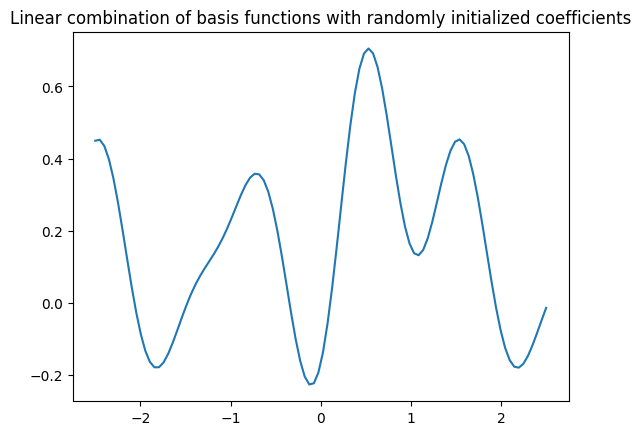

In [5]:
x = np.linspace(-2.5, 2.5, 100)
y = [func_tt(0, torch.tensor([x[i]])).detach().numpy() for i in range(100)]
plt.plot(x, y)
plt.title("Linear combination of basis functions with randomly initialized coefficients")

In [12]:
# Training parameters
n_samples = 1024
n_epochs = 100
batch_size = 256
learning_rate = 1e-3

In [7]:
# Step function
def step_func(x: torch.tensor):
    result = []
    for i in range(len(x)):
        if x[i] <= -0.5:
            result.append(1.)
        elif x[i] <= 0:
            result.append(-1.)
        elif x[i] <= 0.5:
            result.append(1.)
        else:
            result.append(-1.)
    return torch.tensor(result)

In [13]:
# Generate some labeled training data from ground truth function
def generate_data(n_samples: int = 1000, noise: float = 0.0):

    x = torch.tensor(np.linspace(-2.5, 2.5, n_samples))
    
    # y = torch.sin(x * 2 * np.pi)
    # y = step_func(x)
    y = 1 / torch.sqrt(torch.tensor(2) * torch.pi) * torch.exp(- x ** 2 / 2)

    # Add optional noise to the input points
    if noise > 0:
        x += noise * torch.randn(n_samples)

    return x, y

Text(0.5, 1.0, 'Ground truth function')

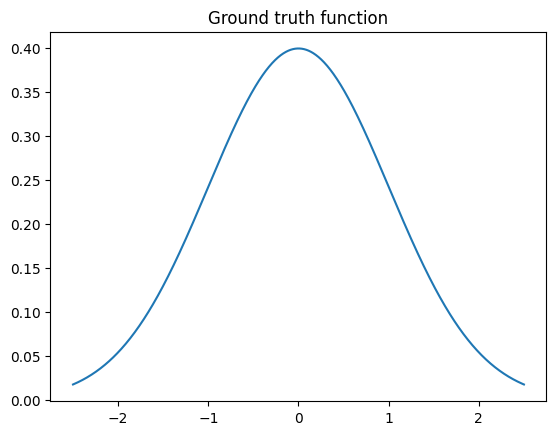

In [14]:
# Plot ground truth function
data = generate_data(noise=0.0)
plt.plot(data[0], data[1])
plt.title("Ground truth function")

In [15]:
# Initialize data and model
data, target = generate_data(n_samples)
# Set the model to training mode and choose optimizer
func_tt.train()
optimizer = optim.AdamW(func_tt.parameters(), lr=learning_rate, weight_decay=0.0)
# Loss function
def loss_func(model, x, y):
    lambda_tt_reg = 0.001
    y_pred = torch.concatenate([model(0, torch.tensor([x[i]])) for i in range(len(x))])
    tt_regularization = sum(torch.norm(core, p="fro") for core in func_tt.tt_cores)
    result = ((y_pred - y) ** 2)
    return result.mean() + lambda_tt_reg * tt_regularization

In [16]:
# List to store the loss over epochs
loss_history = []

# Training loop
for epoch in range(n_epochs):
    indices = torch.randperm(n_samples)
    for i in range(0, n_samples, batch_size):
        batch_indices = indices[i:i + batch_size]
        x_batch = data[batch_indices]
        y_batch = target[batch_indices]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Calculate loss
        loss = loss_func(func_tt, x_batch, y_batch)

        # Backpropagation
        loss.backward()
        optimizer.step()

    # Store the loss value for plotting
    loss_history.append(loss.item())

    if (epoch + 1) % 1 == 0:
        print(f"Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}")

Epoch [1/100], Loss: 0.0081
Epoch [2/100], Loss: 0.0079
Epoch [3/100], Loss: 0.0065
Epoch [4/100], Loss: 0.0067
Epoch [5/100], Loss: 0.0056
Epoch [6/100], Loss: 0.0052
Epoch [7/100], Loss: 0.0050
Epoch [8/100], Loss: 0.0044
Epoch [9/100], Loss: 0.0045
Epoch [10/100], Loss: 0.0039
Epoch [11/100], Loss: 0.0040
Epoch [12/100], Loss: 0.0035
Epoch [13/100], Loss: 0.0030
Epoch [14/100], Loss: 0.0029
Epoch [15/100], Loss: 0.0024
Epoch [16/100], Loss: 0.0021
Epoch [17/100], Loss: 0.0021
Epoch [18/100], Loss: 0.0019
Epoch [19/100], Loss: 0.0017
Epoch [20/100], Loss: 0.0019
Epoch [21/100], Loss: 0.0019
Epoch [22/100], Loss: 0.0015
Epoch [23/100], Loss: 0.0014
Epoch [24/100], Loss: 0.0015
Epoch [25/100], Loss: 0.0014
Epoch [26/100], Loss: 0.0014
Epoch [27/100], Loss: 0.0014
Epoch [28/100], Loss: 0.0012
Epoch [29/100], Loss: 0.0012
Epoch [30/100], Loss: 0.0010
Epoch [31/100], Loss: 0.0011
Epoch [32/100], Loss: 0.0012
Epoch [33/100], Loss: 0.0011
Epoch [34/100], Loss: 0.0010
Epoch [35/100], Loss: 0

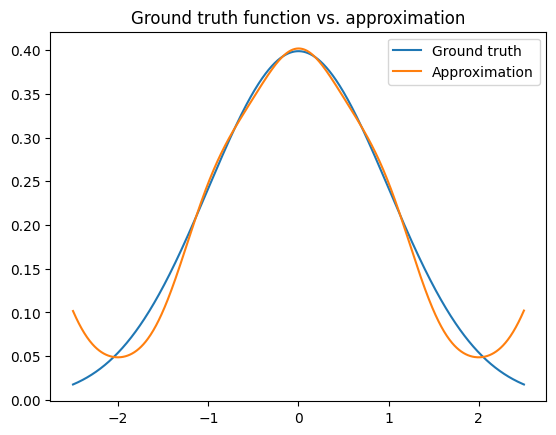

In [17]:
x = np.linspace(-2.5, 2.5, 1000)
y = [func_tt(0, torch.tensor([x[i]])).detach().numpy() for i in range(1000)]
plt.plot(data, target, label="Ground truth")
plt.plot(x, y, label="Approximation")
plt.title("Ground truth function vs. approximation")
plt.legend()